# <span style='color:SteelBlue'>PB6 - Classification automatique de produits (part 2)</span>

<img src="https://logo-marque.com/wp-content/uploads/2020/11/Flipkart-Logo.png" width="300" height="200">

# <span style='background:white; color:black'>Sommaire</span>

**Introduction**

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

Importation des donnees <br>

**Etape 1 : Présentation du dataset**
- _1/ Aperçu tableau_
- _2/ Structure_
- _3/ Valeurs manquantes_
- _4/ Doublons_
- _5/ Inspections des données_
- _6/ Autorisation d'utilisation_

**Etape 2 : Extraction des features image**
- _1/ Nettoyage_
- _2/ EDA_
- _3/ Sauvegarde du dataframe_

**Etape 3 : Faisabilité classification automatique**
- _1/ SIFT_
- _2/ CNN Transfer learning_

**Conclusion**

# <span style='background:blue'>Introduction</span>

L'entreprise **"Flipkart"** est une entreprise indienne qui souhaite lancer une
marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs
proposent des articles à des acheteurs en postant une photo et une description.
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne
de nouveaux articles) et des acheteurs (faciliter la recherche de produits) 
la plus fluide possible, et dans l'optique d'un passage à l'échelle, 
il devient nécessaire **d'automatiser l'attribution de la catégorie** d'un 
article (actuellement effectuée manuellement par les vendeurs, donc peu 
fiable).
___
**Missions**<br>
1/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une **description** pour automatiser l’attribution
de catégorie de l’article. 

2/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une **image** pour automatiser l’attribution
de catégorie de l’article. 

3/ **Réaliser une classification supervisée** à partir des images par la mise
en place d’une data augmentation afin d’optimiser le modèle. 

4/ **Extraire les 10 premiers produits à base de « champagne »** issus de
l’API fournie dans un fichier “.csv”, contenant pour chaque produit les
données suivantes : foodId, label, category, foodContentsLabel, image.
___
Ce notebook presente la 2ème partie concernant la faisabilité d'un moteur de
classification à partir de l'image. Nous allons donc analyser les
images des produits en réalisant :
-	1 prétraitement des données texte ou image suivant le cas.
-	1 extraction des features par différentes méthodes :
    - Pour les données textuelles :
      - 2 approches de type “bag-of-words” avec comptage simple de mots et Tf-idf
      - 1 approche de type word/sentence embedding classique avec Word2Vec
      - 1 approche de type word/sentence embedding avec BERT
      - 1 approche de type word/sentence embedding avec USE
    - Pour les données images :
      - 1 algorithme de type SIFT/ ORB / SURF
      - 1 algorithme de type CNN Transfer Learning
-	1 réduction en 2 dimensions, afin de projeter les produits sur un
    graphique 2D, sous la forme de points dont la couleur correspondra à la
    catégorie réelle
-	1 analyse graphique pour déduire la faisabilité de regroupement
    automatique. 
-	1 calcul de similarité entre les catégories réelles et les catégories
issues d’une segmentation en clusters pour confirmer notre analyse visuelle.
___
**Source des datasets**<br>
Source : Non précisé<br>
___

# <span style='background:grey'>Importations des librairies</span>

In [1]:
# Librairies generales
import os.path
import sys
from IPython.display import display
import time
from datetime import datetime
from tqdm import tqdm
import concurrent.futures

# Librairies data science
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

# SIFT
from matplotlib.image import imread
import cv2

# CNN Transfer learning
import tensorflow as tf
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array

# machine learning
import sklearn
from sklearn import preprocessing
from sklearn import cluster, metrics, manifold, decomposition
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisees :")
print("Python        : " + sys.version)
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.version.full_version)
print("OpenCV        : " + cv2.__version__)
print("Pandas        : " + pd.__version__)
print("Seaborn       : " + sns.__version__)
print("Sklearn       : " + sklearn.__version__)
print("Tensorflow    : " + tf.__version__)

# Nombre de coeurs
nbr_coeur = os.cpu_count()
print(f"\nNombre de coeur disponible(s) sur ce PC: {nbr_coeur} coeur(s)")

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on


Version des librairies utilisees :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
OpenCV        : 4.9.0
Pandas        : 2.1.4
Seaborn       : 0.13.0
Sklearn       : 1.3.2
Tensorflow    : 2.15.0

Nombre de coeur disponible(s) sur ce PC: 12 coeur(s)

Code lance le : 2024-01-22T17:18:18.652704



# <span style='background:grey'>Paramètres d'affichage</span>

In [2]:
# parametrage des paramètres d'affichage dans le notebook
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 50)
pd.set_option("display.precision", 2)

# Ignorer les messages d'avertissement de tensorflow
tf.get_logger().setLevel('ERROR')

# Desactiver la limite de taille des images
Image.MAX_IMAGE_PIXELS = None

# <span style='background:grey'>Fonctions</span>

In [3]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée totale depuis un temps de
    début donné.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """

    # Calculer la durée totale
    total_time = time.time() - start_time

    # Convertir en minutes et secondes
    minutes, seconds = divmod(total_time, 60)

    # Afficher la durée totale
    message = (
        "Durée totale pour faire tourner le notebook : "
        "{0} minute(s) {1} seconde(s)"
    )
    print(message.format(int(minutes), int(seconds)))

In [4]:
def list_fct(name, df_image):
    """
    Cette fonction prend en entrée un nom de produit et renvoie une liste
    contenant les noms des images correspondantes.

    Paramètres :
    name (str) : Le nom du produit pour lequel nous voulons obtenir les images.
    df_image (dataframe) : Le dataframe contenant les noms des images et les
    noms des produits.

    Retourne :
    list_image_name (list) : Une liste contenant les noms des images
    correspondant au produit donné.
    """
    list_image_name = [
        df_image["image"][i] for i in range(len(df_image))
        if df_image["product_name"][i] == name]

    return list_image_name

In [5]:
def pretraitement_detection_descripteur(image_path, sift, keypoint_nbr=500):
    """
    Cette fonction traite une image pour améliorer son contraste et détecter
    ses points clés en respectant un nombre maximum de points clés.

    Args:
        image_path (str): Le chemin vers l'image à traiter.
        sift (cv2.xfeatures2d.SIFT_create): L'objet SIFT.
        keypoint_nbr (int): Le nombre maximum de points clés à détecter
        (par défaut 500).

    Returns:
        des (np.array): Un tableau de descripteurs de points clés.
        kp (list): Liste des points clés détectés.
        res (np.array): L'image traitée.
    """
    # Charger l'image en niveaux de gris
    image = cv2.imread(image_path, 0)

    # floutage type "poivre et sel"
    image = cv2.medianBlur(image, 5)

    # filtrage bruit type "gaussien"
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Egalisation de l'histogramme (amelioration du contraste)
    image = cv2.equalizeHist(image)

    # Redimensionner l'image (divise dimension par 2)
    height, width = image.shape[:2]
    new_width = width // 2
    new_height = height // 2
    res = cv2.resize(image, (new_width, new_height))

    # Detecter les points cles (respecter le nombre maximum de points cles)
    kp, des = sift.detectAndCompute(res, None)

    # Respecter nombre max de points cles (suppr. / ajout descripteurs vides)
    if des is not None:
        if len(des) < keypoint_nbr:
            padding = np.zeros((keypoint_nbr - len(des), 128))
            des = np.concatenate((des, padding), axis=0)
        elif len(des) > keypoint_nbr:
            des = des[:keypoint_nbr]
    else:
        des = np.zeros((keypoint_nbr, 128))

    return des, kp, res

In [6]:
def creation_histogram(kmeans, des, image_num):
    """
    Construit un histogramme normalisé des clusters pour une image donnée.

    Paramètres :
    kmeans (sklearn.cluster.MiniBatchKMeans) : le modèle KMeans utilisé pour
    prédire le cluster de chaque descripteur.
    des (numpy.ndarray) : un tableau de descripteurs SIFT pour une image.
    image_num (int) : le numéro de l'image.

    Retourne :
    hist (numpy.ndarray) : un tableau représentant l'histogramme normalisé des
    clusters.
    """

    # Prédire le cluster de chaque descripteur
    res = kmeans.predict(des)

    # Initialiser un histogramme de zéros de la taille du nombre de clusters
    hist = np.zeros(len(kmeans.cluster_centers_))

    # Obtenir le nombre de descripteurs
    nb_des = len(des)

    # Si il n'y a pas de descripteurs, afficher un message d'erreur
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)

    # Pour chaque prédiction, incrémenter compteur et normaliser histogramme
    for i in res:
        hist[i] += 1.0 / nb_des

    # Retourner l'histogramme
    return hist

In [7]:
def calcul_t_nse_et_clusters(X, labels_reel):
    """
    Calcule une transformation t-SNE des données et effectue un clustering
    KMeans initialisé sur une ACP sur le résultat.
    Mesure également le temps d'exécution et calcule l'indice de Rand ajusté
    (ARI).

    Paramètres:
    X : array-like, shape (n_samples, n_features)
        Les données à transformer et à regrouper.
    labels_reel : array-like, shape (n_samples,)
        Les vraies catégories de chaque point.

    Retourne:
    ARI : float
        L'indice de Rand ajusté, une mesure de la qualité du clustering.
    X_tsne : array-like, shape (n_samples, n_components)
        Les données transformées par t-SNE.
    cls.labels_ : array-like, shape (n_samples,)
        Les clusters attribués à chaque point par KMeans.
    """

    # Lance le timer
    time1 = time.time()

    # t-NSE
    tsne = manifold.TSNE(
        n_components=2,
        perplexity=30,
        n_iter=2000,
        init='random',
        learning_rate=200,
        random_state=42
        )
    X_tsne = tsne.fit_transform(X)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
    cls.fit(X_tsne)

    # Calcul de l'indice de Rand ajusté
    ARI = np.round(metrics.adjusted_rand_score(labels_reel, cls.labels_), 3)

    # Temps d'exécution
    time2 = np.round(time.time() - time1, 0)
    print("Temps t-NSE + cluster : ", time2, "sec")

    return (ARI, X_tsne, cls.labels_)

In [8]:
def comparatif_t_nse_clusters(X_tsne, labels_reel, cls_labels, ARI, methode):
    """
    Visualise les données en utilisant t-SNE, en colorant les points selon
    les vraies catégories et les clusters.

    Paramètres:
    X_tsne : array-like, shape (n_samples, n_components)
        Les données à visualiser, transformées par t-SNE.
    labels_reel : array-like, shape (n_samples,)
        Les vraies catégories de chaque point.
    cls_labels : array-like, shape (n_samples,)
        Les clusters attribués à chaque point.
    ARI : float
        L'indice de Rand ajusté, une mesure de la qualité du clustering.
    methode : str
        Le nom de la méthode utilisée pour le clustering.

    Retourne:
    None
    """

    # LabelEncoder aux labels et transformer les labels
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels_reel)

    # Nom des categories
    labels_unique = labels_reel.unique()

    # Création de la figure
    fig = plt.figure(figsize=(15, 6))

    # plot des vraies catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=labels_encoded,
        cmap='Set1'
        )
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(labels_unique),
        loc="best",
        title="Categorie"
        )
    plt.title(
        f't-NSE / {methode} / cat. reelle', fontsize=20, fontweight='bold')
    plt.xlabel('Dimension 1', fontsize=16)
    plt.ylabel('Dimension 2', fontsize=16)

    # plot des clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=cls_labels,
        cmap='Set1'
        )
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(cls_labels),
        loc="best",
        title="Clusters"
        )
    plt.title(f't-NSE / {methode} / Cluster', fontsize=20, fontweight='bold')
    plt.xlabel('Dimension 1', fontsize=16)
    plt.ylabel('Dimension 2', fontsize=16)

    # Affichage de l'ARI
    plt.show()
    print("ARI : ", ARI)

In [9]:
def conf_mat_transform_argmax(y_true, y_pred):
    """
    Transforme les labels prédits en utilisant la valeur maximale de chaque
    colonne.

    Paramètres:
    y_true (array-like): Les vrais labels.
    y_pred (array-like): Les labels prédits.

    Retourne:
    y_pred_transform (Series): Les labels prédits transformés.
    """

    # Calculer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    # Calcule les correspondances (valeurs max de chaque colonne)
    corresp = np.argmax(conf_mat, axis=0)
    print("\nCorrespondance des clusters : ", corresp)

    # Créer un DataFrame avec les vrais labels et les labels prédits
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred

    # Transformer les labels prédits en utilisant la correspondance
    labels['y_pred_transform'] = labels['y_pred'].apply(
        lambda x: corresp[x] if x < len(corresp) else x)

    # Retourner les labels prédits transformés
    return labels['y_pred_transform']

In [10]:
def analyse_par_classe(X_tsne, cls_labels, labels_reel_s, categories):
    """
    Cette fonction analyse les clusters en calculant le nombre d'images par
    cluster, en créant une matrice de confusion, en transformant les labels
    des clusters selon le nombre max par colonne, en affichant une heatmap de
    la matrice de confusion transformée et un rapport de classification.

    Paramètres:
    X_tsne (numpy.ndarray): Les coordonnées t-SNE des images.
    cls_labels (numpy.ndarray): Les labels des clusters.
    labels_reel_s (numpy.ndarray): Les labels réels des images.
    categories (list): Les catégories des labels.

    Retourne:
    conf_mat_trans_df (pandas.DataFrame): La matrice de confusion transformée.
    """
    # Comptage des images par cluster
    X_tsne_df = pd.DataFrame(X_tsne, columns=["tsne1", "tsne2"])
    X_tsne_df = X_tsne_df.assign(cluster=cls_labels)
    display(X_tsne_df.groupby("cluster").count()["tsne1"])

    # Matrice de confusion initiale
    conf_mat = metrics.confusion_matrix(
        labels_reel_s, X_tsne_df["cluster"])

    # Somme des lignes et des colonnes
    row_sums = np.sum(conf_mat, axis=1)
    col_sums = np.sum(conf_mat, axis=0)
    print("\nSum of rows:", row_sums)
    print("Sum of columns:", col_sums)

    # Transformations des clusters prédits selon le nombre max par colonne
    cls_labels_transform = conf_mat_transform_argmax(
        labels_reel_s, X_tsne_df["cluster"])

    # Matrice de confusion transformée
    conf_mat_trans = metrics.confusion_matrix(
        labels_reel_s, cls_labels_transform)

    # Transformation en dataFrame
    conf_mat_trans_df = pd.DataFrame(
        conf_mat_trans,
        index=[label for label in sorted(categories)],
        columns=[i for i in "0123456"]
        )

    # Heatmap de la matrice de confusion transformée
    print("\nMatrice de confusion transformée :")
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat_trans_df, annot=True, cmap="Blues")
    plt.show()

    # Affichage du rapport de classification
    print(metrics.classification_report(
        labels_reel_s, cls_labels_transform, zero_division=1))

    return conf_mat_trans_df

# <span style='background:grey'>Importation des donnees</span>

Importation des fichiers CSV avec Pandas

In [11]:
# Definir le chemin
chemin = "./data/source/"

# Obtenir une liste de tous les fichiers dans le repertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide et display de la liste des fichiers importe
data_brut = {}
display("===> Liste des fichiers importes: <====\n")

# POUR chaque fichier
for fichier in fichiers:

    # Traiter uniquement les fichiers .csv
    if fichier.endswith(".csv"):
        display(fichier)

        # Lire le fichier csv et le stocker dans le dictionnaire
        data_brut[fichier] = pd.read_csv(
            chemin + fichier,
            sep=",",
            encoding="utf-8"
        )

'===> Liste des fichiers importes: <====\n'

'flipkart_com-ecommerce_sample_1050.csv'

# <span style='background:blue'>Etape 1 : Présentation du dataset</span>

## <span style='background:green'>1/ Aperçu tableau</span>

Nous affichons le début, la fin et des échnatillons au hasard du tableau.

In [12]:
fichier = data_brut["flipkart_com-ecommerce_sample_1050.csv"]
fichier.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   
2  No rating available  No rating available   Eurospa   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...

In [13]:
fichier.tail(3)

uniq_id            crawl_timestamp  \
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049        1190.0             595.0  f2f027ad6a6df617c9f125173da71e44.jpg   

      is_FK_Advantage_product  \
1047                    False   
1048                    False   
1049                    False   

                                            description       product_rating  \
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...  No rating available   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...  No rating available   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...                    4   

           overall_rating       brand  \
1047  No rating available    Uberlyfe   
1048  No rating available  Wallmantra   
1049                    4    Uberlyfe   

                                 product_specifications  
1047  {"product_specification"=>[{"key"=>"Number of ...  
1048  {"product_specification"=>[{"key"=>"Number of ...  
1049  {"product_specification"=>[{"key"=>"Sales Pack...

In [14]:
fichier.sample(3)

uniq_id            crawl_timestamp  \
850  fc009e0b404034e5ea065ba980917f33  2015-12-29 05:07:38 +0000   
47   d1899ab1d5c79ddaa311bc9f04d198ed  2016-03-20 14:44:44 +0000   
822  3fd4d7ea04624ada39fde3957c7b9b7c  2016-05-08 09:23:06 +0000   

                                           product_url  \
850  http://www.flipkart.com/techone-portable-power...   
47   http://www.flipkart.com/d-link-dap1320/p/itmeg...   
822  http://www.flipkart.com/bharatcraft-wall-hangi...   

                                          product_name  \
850  Techone+ Portable Power Bank, and Laptops_2 se...   
47                                      D-Link DAP1320   
822  Bharatcraft Wall Hanging Of Lord Ganesha On A ...   

                                 product_category_tree               pid  \
850  ["Computers >> Laptop Accessories >> USB Gadge...  USGEE5MZ6CAMSUYT   
47   ["Computers >> Network Components >> Routers >...  RTREGG8F83DMYHPE   
822  ["Home Decor & Festive Needs >> Showpiece >> B...  SHIEGFC2FMKUGNZZ   

     retail_price  discounted_price                                 image  \
850         299.0             138.0  fc009e0b404034e5ea065ba980917f33.jpg   
47         3500.0            1978.0  d1899ab1d5c79ddaa311bc9f04d198ed.jpg   
822        1999.0            1124.0  3fd4d7ea04624ada39fde3957c7b9b7c.jpg   

     is_FK_Advantage_product  \
850                    False   
47                     False   
822                    False   

                                           description       product_rating  \
850  Buy Techone+ Portable Power Bank, and Laptops_...  No rating available   
47   Key Features of D-Link DAP1320 QRS app(iOS,And...  No rating available   
822  Key Features of Bharatcraft Wall Hanging Of Lo...  No rating available   

          overall_rating        brand  \
850  No rating available     Techone+   
47   No rating available       D-Link   
822  No rating available  Bharatcraft   

                                product_specifications  
850  {"product_specification"=>[{"key"=>"Brand", "v...  
47   {"product_specification"=>[{"key"=>"Wireless S...  
822  {"product_specification"=>[{"key"=>"Brand", "v...

Informations sur les features :
- **uniq_id** : identifiant unique du produit
- **crawl_timestamp** :  date de récupération des données
- **product_url** : url du produit 
- **product_name** : nom du produit
- **product_category_tree** : Arborescence pour
    atteindre la catégorie du produit
- **pid** : identifiant de processus ou identifiant perenne
- **retail_price** : prix de vente (monnaie inconnue)
- **discounted_price** : prix de vente avec remise
    (monnaie inconnue)
- **image** : nom du fichier JPEG de l'image du produit
- **is_FK_Advantage_product** : produit avantageux Flipkart (Oui/Non)
- **description** : description du produit
- **product_rating** : note du produit
- **overall_rating** : note globale
- **brand** : marque du produit
- **product_specifications** : spécifications du produit

## <span style='background:green'>2/ Structure</span>

Nous affichons la structure du tableau. Nous comptons également le nombre de
features par type et le nombre de valeurs uniques par feature. 

In [15]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [16]:
fichier.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [17]:
tmp = fichier.nunique()
tmp

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

Le fichier contient 1_050 lignes et 15 colonnes. Il y a une majorité de données de type object (12/15). Pour autant, il y a 3 features qui ne sont pas dans le format attendu :
- **crawl_timestamp** : format object au lieu de datetime
- **product_rating** : format object au lieu de int/float
- **overall_rating** : format object au lieu de int/float

## <span style='background:green'>3/ Valeurs manquantes</span>

In [18]:
fichier.isna().sum().sort_values(ascending=False)

brand                      338
retail_price                 1
discounted_price             1
product_specifications       1
uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
dtype: int64

In [19]:
missing_values = fichier.isna().mean()
columns_with_na = missing_values[missing_values > 0].sort_values(
    ascending=False)
display(columns_with_na)

brand                     3.22e-01
retail_price              9.52e-04
discounted_price          9.52e-04
product_specifications    9.52e-04
dtype: float64

Il y a 1 valeur manquante dans les features "retail_price", 
"discounted_price", "product_specifications".

Il y a 338 valeurs (1/3) manquantes dans les features "brand".

## <span style='background:green'>4/ Doublons</span>

Nous vérifions tout d'abord qu'il n'y a pas 2 lignes doublons. Puis nous observons les valeurs doublons par feature. 

In [20]:
fichier.duplicated().sum()

0

In [21]:
for col in fichier.columns:
    n = fichier.duplicated(subset=[col]).sum()
    print(f"col : {col} -> duplicated : {n}")

col : uniq_id -> duplicated : 0
col : crawl_timestamp -> duplicated : 901
col : product_url -> duplicated : 0
col : product_name -> duplicated : 0
col : product_category_tree -> duplicated : 408
col : pid -> duplicated : 0
col : retail_price -> duplicated : 695
col : discounted_price -> duplicated : 625
col : image -> duplicated : 0
col : is_FK_Advantage_product -> duplicated : 1048
col : description -> duplicated : 0
col : product_rating -> duplicated : 1023
col : overall_rating -> duplicated : 1023
col : brand -> duplicated : 559
col : product_specifications -> duplicated : 65


Il n'y a pas de ligne doublons. En revanche, il y a des valeurs doublons dans plusieurs features. 

## <span style='background:green'>5/ Inspection des données</span>

Resume des features **quantitatives** :

In [22]:
fichier.describe().round(2)

retail_price  discounted_price
count       1049.00           1049.00
mean        2186.20           1584.53
std         7639.23           7475.10
min           35.00             35.00
25%          555.00            340.00
50%          999.00            600.00
75%         1999.00           1199.00
max       201000.00         201000.00

Resume des features **qualitatives** : 

In [23]:
fichier.describe(exclude=[np.number, "datetime64[ns]"])

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   

                                       image is_FK_Advantage_product  \
count                                   1050                    1050   
unique                                  1050                       2   
top     55b85ea15a1536d46b7190ad6fff8ce7.jpg                   False   
freq                                       1                     993   

                                              description  \
count                                                1050   
unique                                               1050   
top     Key Features of Elegance Polyester Multicolor ...   
freq                                                    1   

             product_rating       overall_rating         brand  \
count                  1050                 1050           712   
unique                   27                   27           490   
top     No rating available  No rating available  PRINT SHAPES   
freq                    889                  889            11   

                                   product_specifications  
count                                                1049  
unique                                                984  
top     {"product_specification"=>[{"key"=>"Type", "va...  
freq                                                   22

## <span style='background:green'>6/ Autorisation d'utilisation</span>

Notre client nous a confirmé que les textes et les images sont libres de droit.
Ils peuvent être utilisés et modifiés pour sans aucune contrainte de proriété
intellectuelle.

<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'flipkart_com-ecommerce_sample_1050'** contient 15 features 
concernant 1_050 produits vendus sur le site de e-commerce Flipkart.com.
Les textes et images sont libres de droit.

Les données timestamp ne sont pas dans un format de datetime standard.<br>
Les données de score ne sont pas dans un format de nombre (str ou float).<br>
Il manque le prix d'1 produit et le nom de la marque de 338 produits.<br>

# <span style='background:blue'>Etape 2 : Extraction des features image</span>

## <span style='background:green'>1/ Nettoyage</span>

### <span style='background:black'>a/ Sélection des features</span>

Voici la feature qui contient le nom du fichier image du produit.

In [24]:
fichier["image"]

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

Voici la feature qui contient la catégorie du produit.

In [25]:
fichier["product_category_tree"]

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

Nous créons un nouveau dataframe avec ces 2 features précédentes.

In [26]:
cols = ["image", "product_category_tree"]
data_raw = fichier[cols]
data_raw.head()

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                               product_category_tree  
0  ["Home Furnishing >> Curtains & Accessories >>...  
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...

### <span style='background:black'>b/ Détermination de la catégorie du produit</span>

Nous splittons la feature "product_category_tree" pour obtenir uniquement la catégorie principale du produit dans la feature "target".

In [27]:
data_raw.loc[:, 'product_name'] = \
    data_raw.loc[:, 'product_category_tree'].str.split(
        '>>').str[0].str.lstrip('["')
data_raw.head(3)

C:\Users\pierr\AppData\Local\Temp\ipykernel_22220\2766752290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw.loc[:, 'product_name'] = \


image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                               product_category_tree      product_name  
0  ["Home Furnishing >> Curtains & Accessories >>...  Home Furnishing   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        Baby Care

Nous supprimons la feature "product_category_tree" qui ne nous sert plus. 

In [28]:
df_image = data_raw.copy()
df_image.drop("product_category_tree", axis=1, inplace=True)
df_image.head(3)

image      product_name
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing 
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care 
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care

### <span style='background:black'>c/ Détermination du chemin exact des images</span>


In [29]:
path_image = "./data/source/Images/"
df_image['image'] = df_image['image'].apply(lambda x: path_image + x)
df_image.head(3)

image      product_name
0  ./data/source/Images/55b85ea15a1536d46b7190ad6...  Home Furnishing 
1  ./data/source/Images/7b72c92c2f6c40268628ec5f1...        Baby Care 
2  ./data/source/Images/64d5d4a258243731dc7bbb1ee...        Baby Care

### <span style='background:black'>d/ Vérification Nan</span>

Nous vérifions qu'il n'y a aucun Nan dans le dataframe.

In [30]:
df_image.isna().sum()

image           0
product_name    0
dtype: int64

### <span style='background:black'>e/ Vérification doublons</span>

Nous vérifions qu'il n'y a aucun doublon dans le dataframe.

In [31]:
idx = df_image.duplicated(subset="image", keep="first")
idx.sum()

0

## <span style='background:green'>2/ EDA</span>

### <span style='background:black'>a/ Product_name</span>

In [32]:
df_image.product_name.value_counts(normalize=False)

product_name
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

<Axes: ylabel='count'>

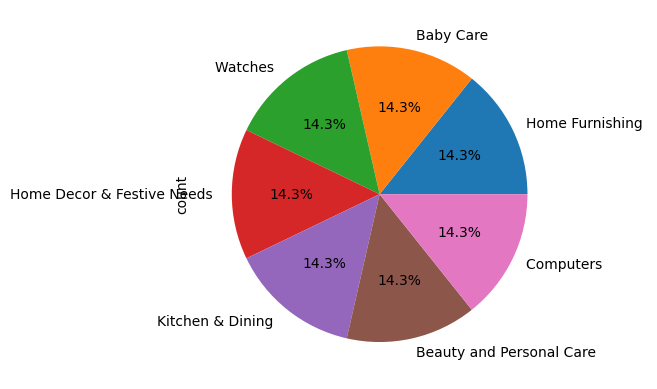

In [33]:
df_image.product_name.value_counts().plot(kind="pie", autopct='%1.1f%%')

La feature "product_name" comprend 7 catégories de produits qui sont toutes réparties équitablement dans le dataframe avec 150 produits par catégorie.

### <span style='background:black'>b/image</span>

**Visualisation des images par catégories de produits.**

In [34]:
le = preprocessing.LabelEncoder()
le.fit(df_image["product_name"])
df_image["label"] = le.transform(df_image["product_name"])
df_image.head(5)

image      product_name  label
0  ./data/source/Images/55b85ea15a1536d46b7190ad6...  Home Furnishing       4
1  ./data/source/Images/7b72c92c2f6c40268628ec5f1...        Baby Care       0
2  ./data/source/Images/64d5d4a258243731dc7bbb1ee...        Baby Care       0
3  ./data/source/Images/d4684dcdc759dd9cdf4150469...  Home Furnishing       4
4  ./data/source/Images/6325b6870c54cd47be6ebfbff...  Home Furnishing       4

Home Furnishing 
-------
Dim. image 0 : 2455 x 4433 pixels
Dim. image 1 : 1100 x 763 pixels
Dim. image 2 : 1455 x 2043 pixels


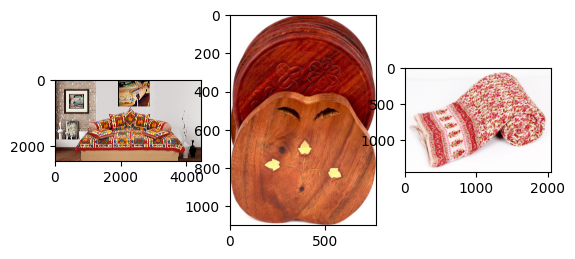

Baby Care 
-------
Dim. image 0 : 1100 x 1024 pixels
Dim. image 1 : 1576 x 2389 pixels
Dim. image 2 : 1183 x 1358 pixels


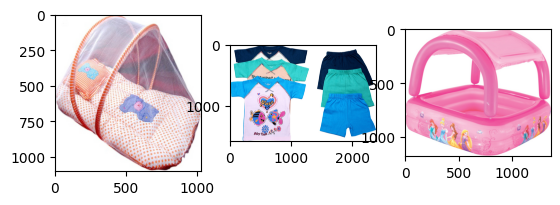

Watches 
-------
Dim. image 0 : 1024 x 751 pixels
Dim. image 1 : 1000 x 302 pixels
Dim. image 2 : 1100 x 1062 pixels


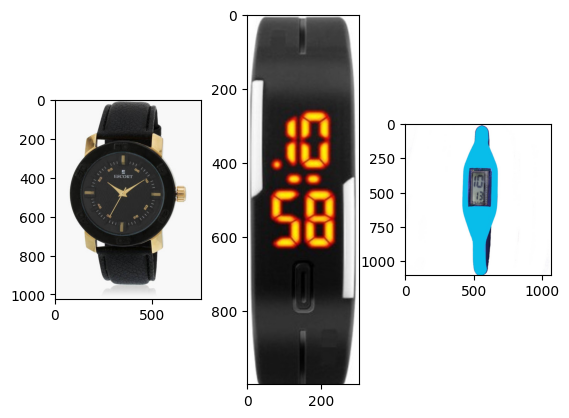

Home Decor & Festive Needs 
-------
Dim. image 0 : 1124 x 834 pixels
Dim. image 1 : 1974 x 1644 pixels
Dim. image 2 : 810 x 1100 pixels


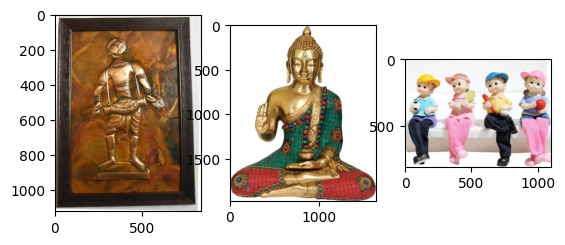

Kitchen & Dining 
-------
Dim. image 0 : 2495 x 1944 pixels
Dim. image 1 : 2357 x 3233 pixels
Dim. image 2 : 539 x 1201 pixels


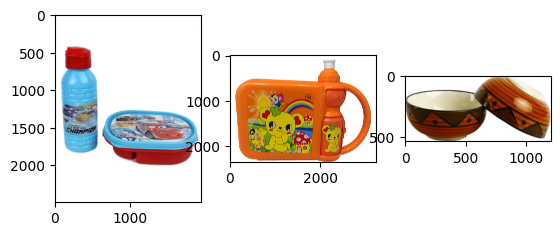

Beauty and Personal Care 
-------
Dim. image 0 : 510 x 1100 pixels
Dim. image 1 : 673 x 1100 pixels
Dim. image 2 : 1600 x 1392 pixels


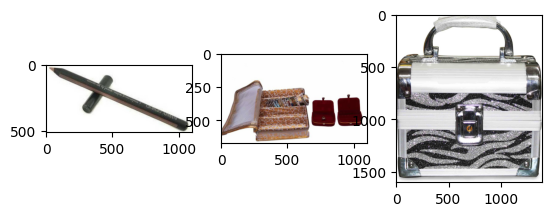

Computers 
-------
Dim. image 0 : 335 x 483 pixels
Dim. image 1 : 1100 x 887 pixels
Dim. image 2 : 345 x 445 pixels


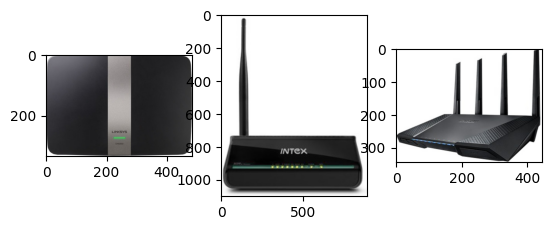

In [35]:
# Obtenez les noms uniques des catégories
categories = df_image['product_name'].unique()

# Afficher les images de 3 produits de chaque catégorie
for nom in categories:
    print(nom)
    print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(nom, df_image)[i + 10]
        image = imread(filename)
        print(f"Dim. image {i} : {image.shape[0]} x {image.shape[1]} pixels")
        plt.imshow(image)
    plt.show()

**Dimension image**

Nous affichons les dimensions des images en pixels pour avoir une idée de leur dimension. 

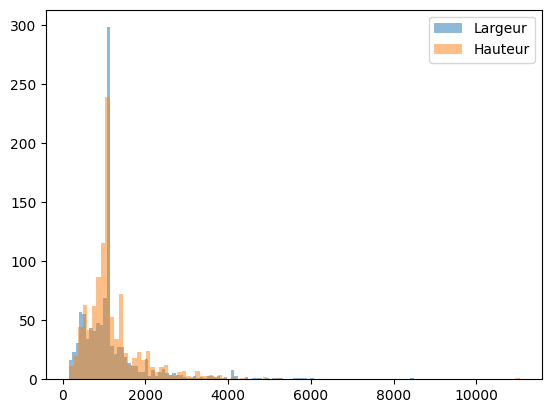

In [36]:
# Liste pour stocker les tailles d'image
image_sizes = []

# Parcourir tous les fichiers dans le répertoire
for filename in df_image['image']:

    # Ouvrir l'image et obtenir sa taille
    with Image.open(filename) as img:
        width, height = img.size
        image_sizes.append((width, height))

# Convertir la liste des tailles en 2 listes séparées (largeurs et hauteurs)
widths, heights = zip(*image_sizes)

# Créer un histogramme pour les largeurs et les hauteurs
plt.hist(widths, bins=100, alpha=0.5, label='Largeur')
plt.hist(heights, bins=100, alpha=0.5, label='Hauteur')
plt.legend(loc='upper right')
plt.show()

In [37]:
# statistiques descriptives de la largeur
widths_series = pd.Series(widths)
widths_series.describe()

count    1050.00
mean     1196.57
std       864.08
min       145.00
25%       747.25
50%      1100.00
75%      1214.25
max      8484.00
dtype: float64

In [38]:
# statistiques descriptives de la hauteur
heights_series = pd.Series(heights)
heights_series.describe()

count     1050.00
mean      1220.04
std        744.84
min        160.00
25%        844.00
50%       1100.00
75%       1360.00
max      11042.00
dtype: float64

Les images ont pour dimension moyenne 1_200 x 1_220 px.

**Les images sont plutôt carrées (ou bien le nombre d'image verticale et horizontale sont équivalents) et relativement grandes.**

## <span style='background:green'>3/ Sauvegarde du dataframe</span>

Nous exportons le dataframe au format CSV pour pouvoir l'utiliser dans le notebook de classification automatique supervisée.

In [39]:
# Chemin du dossier et nom du fichier de l'export des pre-traitements
export_dossier = "data/cleaned"
export_nom = "extraction_feature_image.csv"
export_fichier = os.path.join(export_dossier, export_nom)

# Verification de l'existence du dossier
os.makedirs(export_dossier, exist_ok=True)

# export df feature extraction en CSV (tabulation en separateur)
df_image.to_csv(export_fichier, sep="\t", encoding="utf-8", index=False)

# <span style='background:blue'>Etape 3 : Faisabilité classification automatique</span>

## <span style='background:green'>1/ SIFT</span>

### <span style='background:black'>a/ prétraitement et détection des descripteurs</span>

Nous utilisons la librairie **OpenCV** (cv2) pour appliquer un prétraitement et un algorithme de détection des points d'intérêts et des descripteurs SIFT sur les images. Pour cela, nous réalisons les étapes suivantes :
- 1) Lecture de l'image
- 2) Conversion de l'image en niveaux de gris
- 3) Application d'un filtre de suppression du bruit "poivre et sel"
- 4) Application d'un flou (blur) pour réduire le bruit de haute fréquence
- 5) Amélioration du contraste de l'image via une technique telle que l'égalisation d'histogramme
- 6) Redimensionnement de l'image (réduction de la taille de l'image par un facteur de 2)
- 7) Extraction des keypoints et calcul des descripteurs SIFT

#### **Illustration sur un image d'exemple**

1) Lecture de l'image

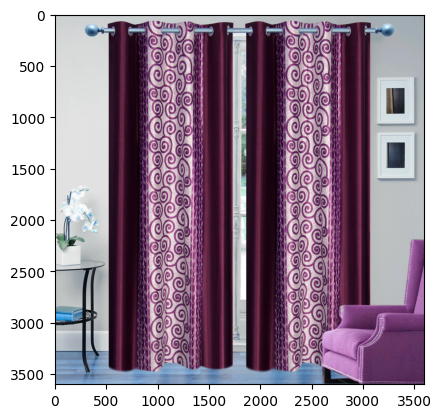

In [39]:
# creation objet SIFT
sift = cv2.SIFT_create()

# numéro de l'image temoin
image_temoin = df_image['image'][0]

# charger l'image initiale
img_ini = cv2.imread(image_temoin, 1)
plt.imshow(img_ini)
plt.show()

2) Conversion de l'image en niveaux de gris

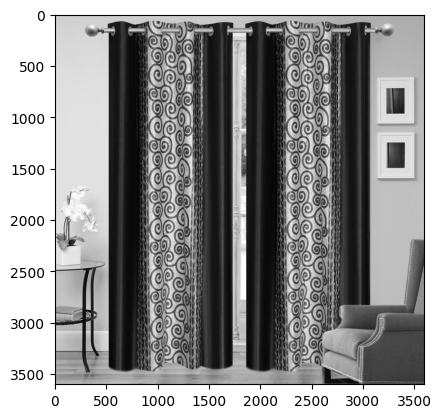

In [40]:
# charger l'image en niveau de gris
img_gris = cv2.imread(image_temoin, 0)
plt.imshow(cv2.cvtColor(img_gris, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

3) Application d'un filtre de suppression du bruit "poivre et sel"

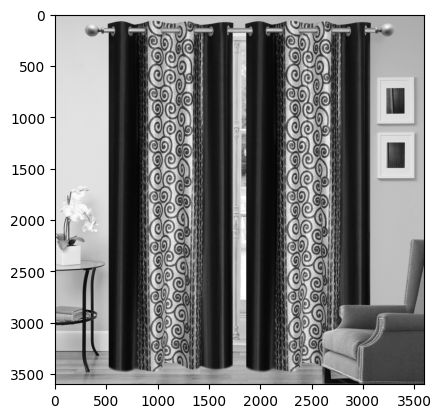

In [41]:
# filtrage du bruit de type "sel et poivre" (noyau gaussien 5x5)
img_filtred = cv2.medianBlur(img_gris, 5)

plt.imshow(cv2.cvtColor(img_filtred, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

4) Application d'un flou (blur) pour réduire le bruit de haute fréquence

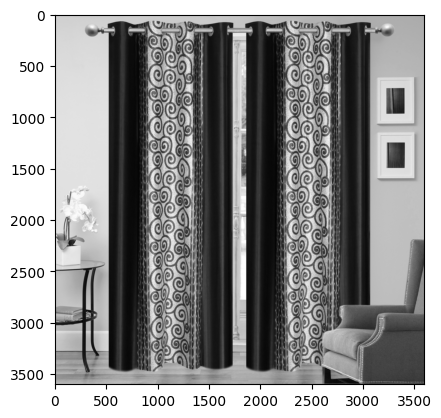

In [42]:
# floutage de l'image (noyau gaussien 5x5 avec ecart-type = 0)
img_flou = cv2.GaussianBlur(img_filtred, (5, 5), 0)

plt.imshow(cv2.cvtColor(img_flou, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

5) Amélioration du contraste de l'image via une technique telle que l'égalisation d'histogramme

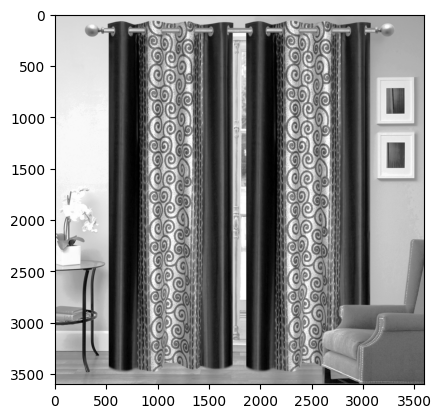

In [43]:
# Egalisation de l'histogramme (amelioration contraste)
img_egal = cv2.equalizeHist(img_flou)

plt.imshow(cv2.cvtColor(img_egal, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

6) Redimensionnement de l'image (réduction de la taille de l'image par un facteur de 2)

*Les images de trop grande dimension induisent des problèmes de mémoire insuffisante sur mon CPU.*

Dimensions originales :  3600  x  3600
Dimensions modifiees :  1800  x  1800


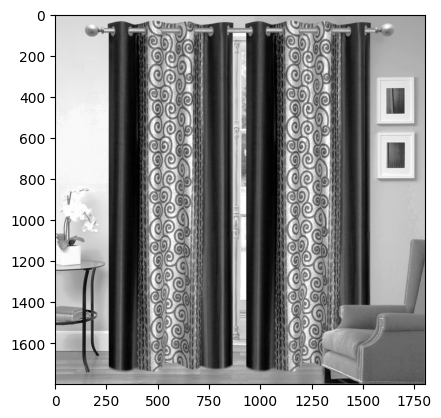

In [44]:
# Obtenir les dimensions originales de l'image
height, width = img_egal.shape[:2]
print("Dimensions originales : ", width, " x ", height)

# Calculer les nouvelles dimensions
new_width = width // 2
new_height = height // 2
print("Dimensions modifiees : ", new_width, " x ", new_height)

# Redimensionner l'image
img_redim = cv2.resize(img_egal, (new_width, new_height))

plt.imshow(cv2.cvtColor(img_redim, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

7) Extraction des keypoints et calcul des descripteurs SIFT

Nous utilisons la fonction *"sift.detectAndCompute"* pour détecter les points d'intérêt (keypoints) et calculer leurs descripteurs (vecteur).

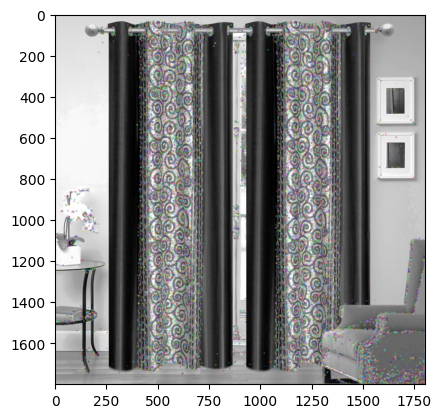

Nombre descripteur :  16800
Taille vecteur descripteur :  128


In [45]:
# detection des points d'interet et leurs descripteurs
kp, des = sift.detectAndCompute(img_redim, None)

# dessiner les points d'interet sur l'image
img = cv2.drawKeypoints(img_redim, kp, img_redim)

plt.imshow(img)
plt.show()

print("Nombre descripteur : ", des.shape[0])
print("Taille vecteur descripteur : ", des.shape[1])

#### **Application sur toutes les images**

Nous appliquons le prétraitement et la détection des descripteurs SIFT sur toutes les images.

Nous limitons le nombre de descripteurs à **500** par image *(pour éviter les problèmes de mémoire insuffisante sur mon CPU)*.

In [46]:
# nombre de descripteurs par image
keypoint_nbr = 500

Nous appliquons la fonction **pretraitement_detection_descripteur** que nous avons crée. 

  0%|          | 0/1050 [00:00<?, ?it/s]

Image 0


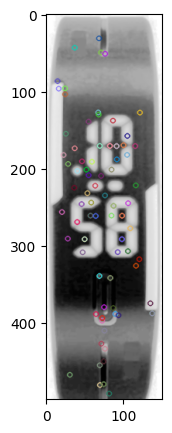

  6%|▌         | 61/1050 [00:01<00:29, 33.00it/s]

 10%|▉         | 100/1050 [00:06<02:16,  6.95it/s]

Image 100


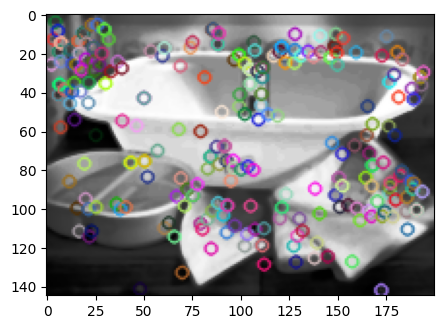

 19%|█▉        | 199/1050 [00:16<01:00, 13.95it/s]

Image 200


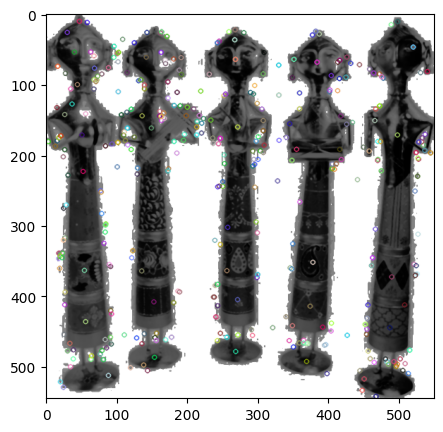

 28%|██▊       | 298/1050 [00:27<02:02,  6.12it/s]

Image 300


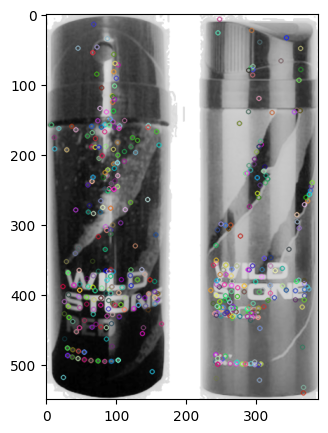

 38%|███▊      | 396/1050 [00:34<00:32, 20.15it/s]

Image 400


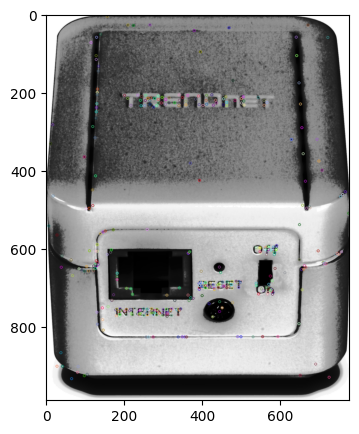

 48%|████▊     | 500/1050 [00:37<00:11, 47.39it/s]

Image 500


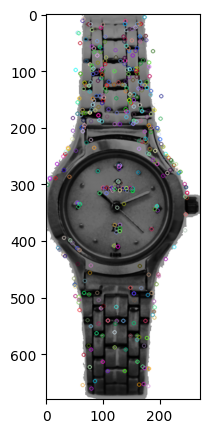

 57%|█████▋    | 600/1050 [00:40<00:12, 35.83it/s]

Image 600


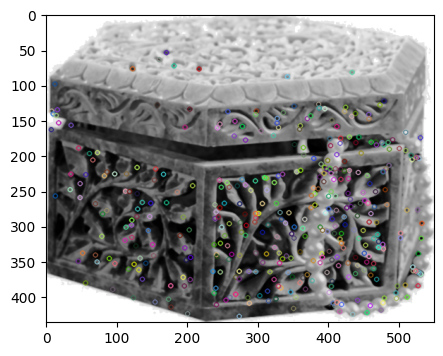

 67%|██████▋   | 699/1050 [00:43<00:12, 28.51it/s]

Image 700


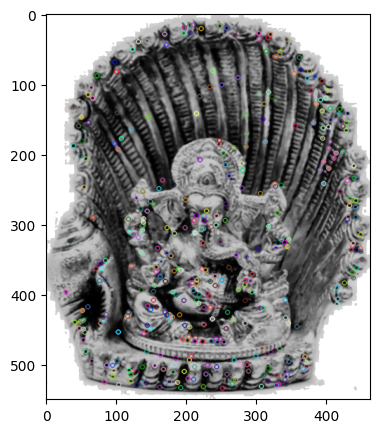

 76%|███████▌  | 800/1050 [01:18<00:21, 11.82it/s]

Image 800


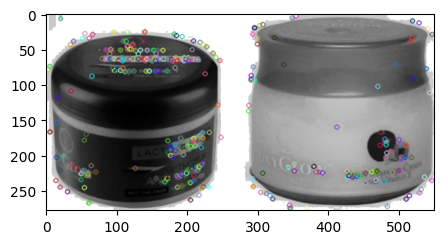

 86%|████████▌ | 900/1050 [01:45<00:42,  3.54it/s]

Image 900


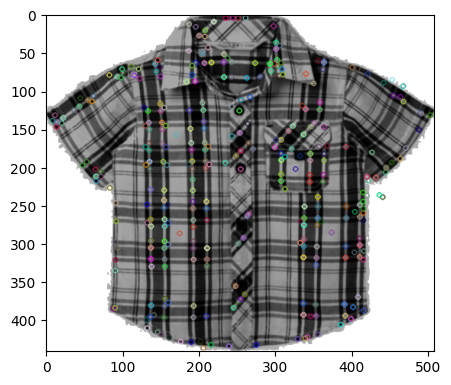

 95%|█████████▌| 1000/1050 [02:08<00:05,  9.15it/s]

Image 1000


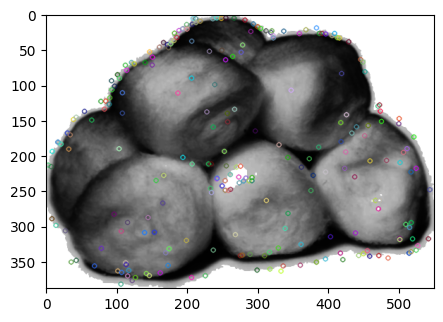

100%|██████████| 1050/1050 [02:41<00:00,  6.51it/s]


Voici le tableau des keypoints:


0     1    2     3     4     5     6      7      8     9    10   \
0        2.0   0.0  0.0   3.0   9.0   3.0   0.0    1.0   22.0   5.0  7.0   
1       52.0   0.0  0.0   0.0   0.0   0.0  70.0   63.0  165.0   0.0  0.0   
2        3.0   2.0  0.0  38.0  98.0  60.0  45.0    8.0  134.0  93.0  0.0   
3       21.0   0.0  0.0   0.0   0.0   1.0   1.0   14.0  165.0   1.0  0.0   
4        0.0   0.0  0.0   0.0   5.0  44.0  39.0   11.0  149.0   6.0  0.0   
...      ...   ...  ...   ...   ...   ...   ...    ...    ...   ...  ...   
524995  62.0   2.0  0.0   0.0   0.0   0.0   0.0    0.0  197.0  17.0  0.0   
524996  52.0   4.0  0.0   0.0   0.0   0.0   0.0    0.0  144.0  26.0  1.0   
524997  43.0  10.0  0.0   0.0   0.0   0.0   0.0    0.0  177.0  73.0  0.0   
524998  30.0   0.0  0.0   0.0   0.0   0.0   0.0    7.0  168.0   0.0  0.0   
524999  32.0   0.0  0.0   0.0   0.0   0.0   5.0  137.0   58.0   0.0  0.0   

         11    12    13    14     15     16    17   18   19   20   21    22   \
0       30.0  17.0   1.0   0.0    6.0   68.0   4.0  4.0  8.0  2.0  7.0  84.0   
1        0.0   0.0   0.0   5.0   55.0  121.0   1.0  0.0  0.0  7.0  1.0   0.0   
2        5.0  14.0  21.0  21.0    4.0  110.0  65.0  0.0  0.0  0.0  0.0   0.0   
3        0.0   0.0   0.0   0.0   11.0  178.0   3.0  0.0  0.0  0.0  0.0   0.0   
4        0.0  12.0  61.0  11.0   17.0  174.0  33.0  0.0  0.0  0.0  0.0   1.0   
...      ...   ...   ...   ...    ...    ...   ...  ...  ...  ...  ...   ...   
524995   0.0   0.0   0.0   0.0    2.0  124.0   7.0  0.0  0.0  0.0  0.0   0.0   
524996   0.0   0.0   0.0   0.0   41.0  144.0  21.0  1.0  0.0  0.0  0.0   0.0   
524997   0.0   0.0   0.0   0.0    2.0  140.0  29.0  0.0  0.0  0.0  0.0   0.0   
524998   0.0   0.0   0.0   0.0   72.0  162.0   0.0  0.0  0.0  0.0  0.0   0.0   
524999   0.0   0.0   0.0   4.0  137.0   81.0   1.0  0.0  0.0  0.0  0.0   0.0   

          23    24   ...   103    104   105   106   107   108   109    110  \
0        92.0   2.0  ...   1.0    0.0   0.0   0.0   0.0   0.0  10.0  151.0   
1         4.0   9.0  ...   2.0   22.0  24.0  27.0   0.0   0.0   1.0    3.0   
2         0.0   0.0  ...  20.0   59.0  21.0  16.0  89.0  42.0   8.0   11.0   
3         1.0  55.0  ...  16.0  153.0   3.0   0.0   0.0   0.0   0.0    0.0   
4         8.0  70.0  ...   4.0    6.0   2.0   1.0   1.0  11.0  34.0    3.0   
...       ...   ...  ...   ...    ...   ...   ...   ...   ...   ...    ...   
524995    3.0   1.0  ...   0.0  197.0  17.0   0.0   0.0   0.0   0.0    0.0   
524996  102.0  22.0  ...   0.0  144.0  26.0   0.0   0.0   0.0   0.0    0.0   
524997    2.0   1.0  ...  14.0  177.0   8.0   0.0   0.0   0.0   0.0    4.0   
524998   37.0   2.0  ...  20.0  168.0   7.0   0.0   0.0   0.0   0.0    0.0   
524999  137.0  24.0  ...  16.0    0.0   0.0   0.0   0.0   0.0   6.0   13.0   

          111    112   113   114  115  116   117    118   119   120   121  \
0        10.0   20.0   5.0   0.0  0.0  0.0   7.0  151.0  51.0   8.0   8.0   
1         6.0  165.0  28.0   5.0  0.0  0.0   0.0    0.0  24.0  77.0   1.0   
2        16.0  134.0  91.0   2.0  2.0  1.0   0.0    2.0  13.0  38.0  18.0   
3         8.0  178.0   2.0   0.0  0.0  0.0   0.0    0.0   2.0  56.0   0.0   
4         2.0   31.0  66.0  65.0  7.0  7.0  20.0    4.0   2.0   2.0  23.0   
...       ...    ...   ...   ...  ...  ...   ...    ...   ...   ...   ...   
524995    3.0  146.0   6.0   0.0  0.0  0.0   0.0    0.0   2.0   1.0   0.0   
524996   27.0  144.0  19.0   0.0  0.0  0.0   0.0    0.0  66.0  13.0   0.0   
524997  121.0   97.0  28.0   0.0  0.0  0.0   0.0    6.0  65.0   8.0   2.0   
524998   71.0  148.0  10.0   0.0  0.0  0.0   0.0    0.0  48.0   9.0   0.0   
524999    1.0    0.0   0.0   0.0  0.0  0.0   1.0   11.0   5.0   0.0   0.0   

          122   123  124  125   126   127  
0         9.0   1.0  0.0  3.0  69.0  19.0  
1         0.0   0.0  0.0  0.0   0.0   9.0  
2         0.0   0.0  0.0  0.0   0.0   1.0  
3         0.0   0.0  0.0  0.0   0.0   1.0  
4       174.0  36.0  2.0  7.0  10.0   1.0  
...      


Nombre descripteur :  525000
Taille vecteur descripteur :  128

Temps traitement SIFT descriptor :           164.14 secondes


In [47]:
%pycodestyle_off
# lancement du chrono
temps_debut = time.time()

# création objet SIFT (nombre keypoints max) et liste vide
sift = cv2.SIFT_create(keypoint_nbr)
sift_keypoints = []

# Création d'un pool de threads
with concurrent.futures.ThreadPoolExecutor() as executor:

    # Exécution des threads
    futures = [
        executor.submit(
            pretraitement_detection_descripteur, img, sift, keypoint_nbr) for img in df_image['image']
        ]

    # Affichage de l'avancement des threads
    for i, future in enumerate(tqdm(concurrent.futures.as_completed(futures), total=len(futures))):

        # Ajout des descriptions de points clés à la liste
        des, kp, res = future.result()
        sift_keypoints.append(des)

        # Affichage de l'image tous les 500 images
        if i % 100 == 0:
            img_with_kp = cv2.drawKeypoints(res, kp, None)
            print(f"Image {i}")
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
            plt.show()

# Concatenation des descripteurs de toutes les images
sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
sift_keypoints_all_df = pd.DataFrame(sift_keypoints_all)
print("Voici le tableau des keypoints:")
display(sift_keypoints_all_df)

# Affichage des dimensions
print("\nNombre descripteur : ", sift_keypoints_all.shape[0])
print("Taille vecteur descripteur : ", sift_keypoints_all.shape[1])

# Affichage du temps de traitement
duree = time.time() - temps_debut
print("\nTemps traitement SIFT descriptor : ", "%15.2f" % duree, "secondes")
%pycodestyle_on

Nous allons sauvegarder le dataframe pour pouvoir le réutiliser dans un autre notebook si besoin. 

In [48]:
# Chemin du dossier et nom du fichier de l'export des pre-traitements
export_dossier = "data/cleaned"
export_nom = f"extraction_feature_image_sift_keypoints_{keypoint_nbr}.csv"
export_fichier = os.path.join(export_dossier, export_nom)

# Verification de l'existence du dossier
os.makedirs(export_dossier, exist_ok=True)

# export df de pretraitement en CSV (tabulation en separateur)
sift_keypoints_all_df.to_csv(
    export_fichier,
    sep="\t",
    encoding="utf-8",
    index=False
    )

### <span style='background:black'>b/ Création des visuals words</span>

Dans une approche de **"bag-of-image"**, nous créons les visuals words à partir des descripteurs SIFT ("mots"). Pour cela nous effectuons un **clustering** des descripteurs SIFT.

Le nombre de clusters est déterminé par la racine carré du nombre de descripteurs (arrondi). 

In [49]:
# lancement du chrono
temps1 = time.time()

# Determination number of clusters
k = int(round(np.sqrt(sift_keypoints_all_df.shape[0]), 0))
print("Nombre de visual words estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(
    n_clusters=k,
    n_init=3,
    init_size=3 * k,
    random_state=42
    )
kmeans.fit(sift_keypoints_all_df)

# Affichage du temps de traitement
duration1 = time.time() - temps1
print("\ntemps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de visual words estimés :  725
Création de 725 clusters de descripteurs ...



temps de traitement kmeans :             9.19 secondes


### <span style='background:black'>c/ Création du bag-of-visual words</span>

Nous créons un histogramme des visual words pour chaque image.

In [50]:
# Lancez le chrono
temps1 = time.time()

# Initialiser une liste vide pour stocker les histogrammes
hist_vectors = []

# POUR chaque image
for i, image_desc in enumerate(tqdm(sift_keypoints_by_img)):

    # Calculer les histogrammes pour chaque image
    hist = creation_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

# Convertir la liste en tableau numpy
im_features = np.asarray(hist_vectors)

# Aficher le temps ecoule
duration1 = time.time() - temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

# Afficher les features
print("\nVoici les bag of visual words :")
display(pd.DataFrame(im_features))

  5%|▍         | 48/1050 [00:00<00:04, 236.82it/s]

100%|██████████| 1050/1050 [00:02<00:00, 397.06it/s]

temps de création histogrammes :             2.67 secondes

Voici les bag of visual words :


0     1         2         3         4         5    6         7    \
0     0.00e+00  0.81  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.0  0.00e+00   
1     4.00e-03  0.00  0.00e+00  0.00e+00  6.00e-03  8.00e-03  0.0  0.00e+00   
2     0.00e+00  0.00  0.00e+00  2.00e-03  6.00e-03  8.00e-03  0.0  0.00e+00   
3     2.00e-03  0.52  0.00e+00  0.00e+00  2.00e-03  4.00e-03  0.0  8.00e-03   
4     4.00e-03  0.61  0.00e+00  4.00e-03  0.00e+00  0.00e+00  0.0  0.00e+00   
...        ...   ...       ...       ...       ...       ...  ...       ...   
1045  0.00e+00  0.00  2.00e-03  2.00e-03  2.00e-03  0.00e+00  0.0  2.00e-03   
1046  2.00e-03  0.00  0.00e+00  0.00e+00  2.00e-03  0.00e+00  0.0  4.60e-02   
1047  0.00e+00  0.00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.0  0.00e+00   
1048  0.00e+00  0.00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.0  0.00e+00   
1049  0.00e+00  0.00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.0  2.00e-03   

           8         9         10   11        12        13        14   \
0     0.00e+00  0.00e+00  2.00e-03  0.0  0.00e+00  2.00e-03  0.00e+00   
1     8.00e-03  4.00e-03  0.00e+00  0.0  0.00e+00  4.00e-03  0.00e+00   
2     0.00e+00  0.00e+00  4.00e-03  0.0  0.00e+00  0.00e+00  0.00e+00   
3     2.00e-03  0.00e+00  0.00e+00  0.0  0.00e+00  0.00e+00  0.00e+00   
4     0.00e+00  0.00e+00  0.00e+00  0.0  0.00e+00  2.00e-03  2.00e-03   
...        ...       ...       ...  ...       ...       ...       ...   
1045  4.00e-03  0.00e+00  2.00e-03  0.0  4.00e-03  0.00e+00  0.00e+00   
1046  0.00e+00  0.00e+00  2.00e-03  0.0  0.00e+00  1.40e-02  0.00e+00   
1047  0.00e+00  0.00e+00  0.00e+00  0.0  0.00e+00  0.00e+00  0.00e+00   
1048  0.00e+00  0.00e+00  0.00e+00  0.0  8.60e-02  0.00e+00  0.00e+00   
1049  0.00e+00  4.00e-03  1.60e-02  0.0  0.00e+00  2.00e-03  0.00e+00   

           15        16        17   18        19        20   21        22   \
0     0.00e+00  0.00e+00  2.00e-03  0.0  0.00e+00  0.00e+00  0.0  0.00e+00   
1     0.00e+00  0.00e+00  0.00e+00  0.0  4.00e-03  2.00e-03  0.0  2.00e-03   
2     0.00e+00  1.60e-02  4.00e-03  0.0  2.00e-03  1.40e-02  0.0  2.00e-03   
3     0.00e+00  8.00e-03  0.00e+00  0.0  0.00e+00  0.00e+00  0.0  0.00e+00   
4     0.00e+00  2.00e-03  0.00e+00  0.0  0.00e+00  2.00e-03  0.0  1.00e-02   
...        ...       ...       ...  ...       ...       ...  ...       ...   
1045  0.00e+00  8.00e-03  0.00e+00  0.0  2.00e-03  2.00e-03  0.0  4.00e-03   
1046  0.00e+00  0.00e+00  0.00e+00  0.0  0.00e+00  0.00e+00  0.0  0.00e+00   
1047  0.00e+00  2.00e-03  8.00e-02  0.0  2.00e-03  0.00e+00  0.0  0.00e+00   
1048  0.00e+00  4.00e-03  2.00e-03  0.0  0.00e+00  0.00e+00  0.0  2.80e-02   
1049  2.00e-03  0.00e+00  0.00e+00  0.0  0.00e+00  0.00e+00  0.0  0.00e+00   

      23   24   ...       700       701  702  703  704  705  706  707  \
0     0.0  0.0  ...  2.00e-03  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  ...  2.00e-03  4.00e-03  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  ...  2.00e-03  2.00e-03  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  ...  0.00e+00  2.00e-03  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  ...  2.00e-03  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...       ...       ...  ...  ...  ...  ...  ...  ...   
1045  0.0  0.0  ...  8.00e-03  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   
1046  0.0  0.0  ...  0.00e+00  8.00e-03  0.0  0.0  0.0  0.0  0.0  0.0   
1047  0.0  0.0  ...  0.00e+00  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   
1048  0.0  0.0  ...  2.00e-03  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0   
1049  0.0  0.0  ...  0.00e+00  1.00e-02  0.0  0.0  0.0  0.0  0.0  0.0   

           708  709  710  711       712  713  714  715  716  717  718  719  \
0     0.00e+00  0.0  0.0  0.0  0.00e+00  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     2.00e-03  0.0  0.0  0.0  4.00e-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.00e+00  0.0  0.0  0.0  2.00e-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     4.00e-03  0.0  0.0  0.0  0.00e+00  0.0  0.0  0.0  0.0

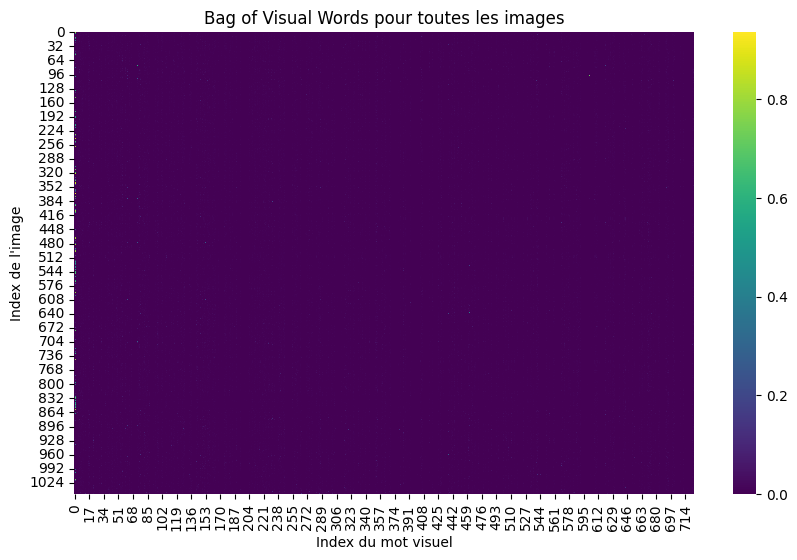

In [51]:
plt.figure(figsize=(10, 6))
sns.heatmap(im_features, cmap='viridis')
plt.title("Bag of Visual Words pour toutes les images")
plt.xlabel("Index du mot visuel")
plt.ylabel("Index de l'image")
plt.show()

Cette heatmap ne nous permet pas de bien visualiser la répartition des visual words par image.

### <span style='background:black'>d/ Réduction de dimension</span>

**ACP**

Nous réduisons la dimension de notre matrice avec une ACP pour améliorer l'apprentissage de notre modèle et diminuer les couts de calcul.

Nous conservons 99% de la variance.

In [52]:
# Créer un scaler, l'ajuster aux données et les transformer
scaler = StandardScaler()
im_features_standardized = scaler.fit_transform(im_features)

print(
    "Dimensions dataset avant ACP : ", im_features_standardized.shape)

# Appliquer l'ACP
pca = decomposition.PCA(n_components=0.99)
feat_pca_sift = pca.fit_transform(im_features_standardized)
print("Dimensions dataset après ACP : ", feat_pca_sift.shape)

Dimensions dataset avant ACP :  (1050, 725)
Dimensions dataset après ACP :  (1050, 562)


99% de la variance est conservée en réduisant le df de 765 features => 561 features. 

**t-NSE**

Nous réduisons la dimension de notre df apres l'ACP avec un t-SNE pour afficher les 2 premières composantes principales.

In [53]:
# Isoler les vraies catégories
labels_reel = df_image['label']

# Calculer t-NSE et clusters
ARI_sift, X_tsne_sift, cls_labels_sift = calcul_t_nse_et_clusters(
    feat_pca_sift,
    labels_reel
    )

Temps t-NSE + cluster :  9.0 sec


**Comparaison catégories réelles Vs catégories clustering</span>**

Nous affichons les 2 dimensions du t-SNE avec les vraies catégories et avec les catégories issues du clustering. Egalement, nous affichons le score de similarité entre les 2 catégories avec la méthode **adjusted_rand_score** (ARI)de la librairie **sklearn**.

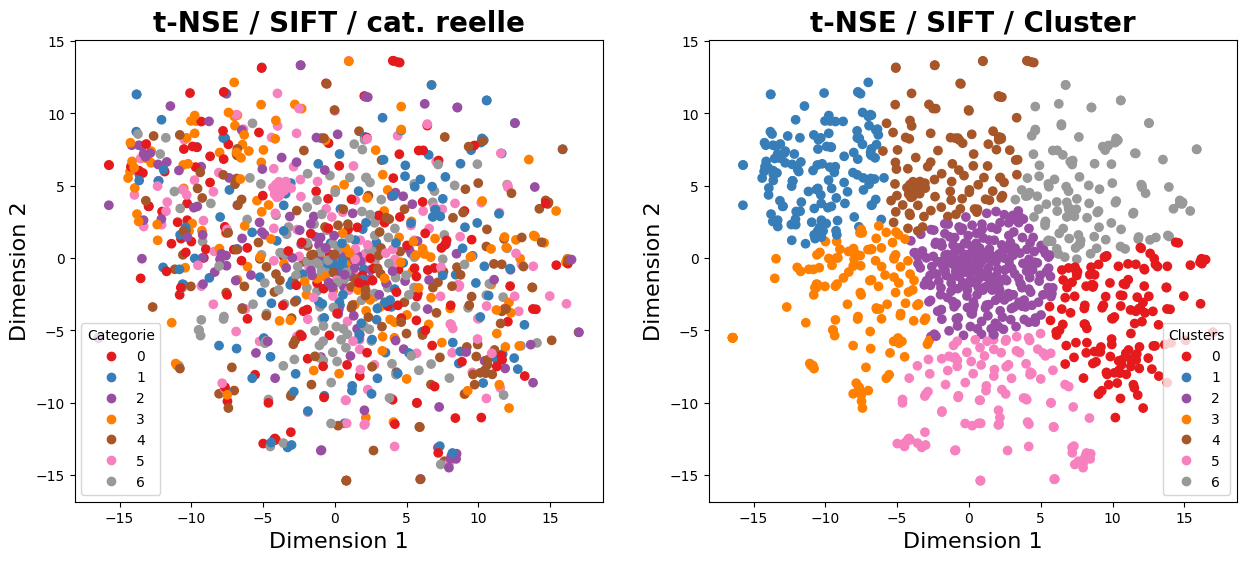

ARI :  0.012


In [54]:
comparatif_t_nse_clusters(
    X_tsne_sift, labels_reel, cls_labels_sift, ARI_sift, "SIFT")

### <span style='background:black'>d/ Analyse par classe</span>

Nous comptons le nombre de mot par cluster, puis nous associons chaque
cluster à une classe réelle.

Nous visualisons la matrice de confusion après l'association.

cluster
0    148
1    147
2    262
3    131
4    122
5    119
6    121
Name: tsne1, dtype: int64


Sum of rows: [150 150 150 150 150 150 150]
Sum of columns: [148 147 262 131 122 119 121]

Correspondance des clusters :  [4 3 6 2 5 6 1]

Matrice de confusion transformée :


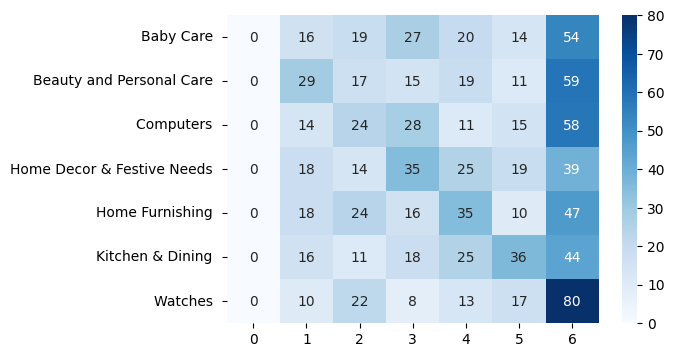

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       150
           1       0.24      0.19      0.21       150
           2       0.18      0.16      0.17       150
           3       0.24      0.23      0.24       150
           4       0.24      0.23      0.23       150
           5       0.30      0.24      0.26       150
           6       0.21      0.53      0.30       150

    accuracy                           0.23      1050
   macro avg       0.34      0.23      0.20      1050
weighted avg       0.34      0.23      0.20      1050



In [55]:
# Serie des vraies catégories
labels_reel_s = pd.Series(df_image["label"], name="categorie_reelle")

# Analyse par classe avec matrice de confusion transformée
conf_mat_sift_df = analyse_par_classe(
    X_tsne_sift, cls_labels_sift, labels_reel_s, categories)

Le f1-score et l'accuracy sont < 30%. Le modèle n'est pas performant.

<div class="alert alert-block alert-info">
<b>
<u>Bilan</u><br>
SIFT
</b> :
La comparaison des catégories réelles et des catégories issues du clustering ne laisse pas penser qu'une classification automatique efficace est possible avec le SIFT. Le score ARI est très très faible (< 0,1).
</div>

## <span style='background:green'>2/ CNN Transfer learning</span>

### <span style='background:black'>a/Création du modèle pré-entraîné</span>

Nous téléchargeons le modèle VGG16 de Google. C'est un modèle  de réseau neuronal convolutif pré-entraîné sur plus d'1 million d'images de la base de données ImageNet. Il est capable de reconnaître 1_000 classes d'objets différents.

Nous supprimons les 2 dernières couches du modèle pour ne garder que la partie convolutionnelle. Nous allons réaliser du **Transfer learning** en utilisant les poids du modèle pré-entraîné pour notre problème de classification.

In [56]:
# Importer le modèle VGG16 (sauf les 2 dernières couches)
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### <span style='background:black'>b/ Création des features des images</span>

Nous créons les **features des images** avec le modèle VGG16

Nous ajoutons une dimension à nos images pour pouvoir spécifier le batch (format d'entrée des modèles de Deep Learning).

Nous prétraitons les images pour les passer dans le modèle VGG16. Ici le prétraitement est celui de la librairie Keras, il est constitué de 3 étapes :
- Redimensionnement de l'image en 224x224 pixels
- Conversion de l'image de RGB en BGR (format attendu par le modèle VGG16)
- Normalisation des valeurs des pixels en soustrayant la moyenne des valeurs de chaque canal (R, G, B) de l'ensemble de la base de données ImageNet pour centrer les données autour de zéro.

In [57]:
# Liste vide et initialisation du compteur
images_features = []
i = 0

# POUR chaque image
for image_file in df_image['image']:

    # Implémenter un compteur pour afficher l'avancement
    if i % 100 == 0:
        print(i)
    i += 1

    # Charger image en la redimensionnant à 224x224 pixels (en tableau numpy)
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)

    # Ajout dimension supplémentaire, prétraitement et prédiction
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0])

# Convertir la liste en tableau numpy
images_features = np.asarray(images_features)
display(images_features)
images_features.shape

0


100
200
300
400
500
600
700
800
900
1000


array([[3.4062781 , 0.85704327, 0.        , ..., 0.        , 0.86586285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.3071439 , 0.        ,
        0.        ],
       ...,
       [2.1931746 , 2.3964314 , 2.630248  , ..., 2.1707265 , 0.18521276,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.22905424,
        0.9220943 ],
       [0.        , 0.        , 0.12173498, ..., 0.        , 0.5422696 ,
        2.969182  ]], dtype=float32)

(1050, 4096)

### <span style='background:black'>c/ Réduction de dimension</span>

**ACP**

Nous réduisons la dimension de notre matrice avec une ACP pour améliorer l'apprentissage de notre modèle et diminuer les couts de calcul.

Nous conservons 99% de la variance.

In [58]:
# Créer un scaler, l'ajuster aux données et les transformer
scaler = StandardScaler()
images_features_standardized = scaler.fit_transform(images_features)

print("Dimensions dataset avant ACP : ", images_features_standardized.shape)

# Appliquer l'ACP
pca = decomposition.PCA(n_components=0.99)
feat_pca_vgg = pca.fit_transform(images_features_standardized)
print("Dimensions dataset après ACP : ", feat_pca_vgg.shape)

Dimensions dataset avant ACP :  (1050, 4096)
Dimensions dataset après ACP :  (1050, 850)


99% de la variance est conservée en réduisant le df de 4096 features => 850 features. 

**t-NSE**

Nous réduisons la dimension de notre df apres l'ACP avec un t-SNE pour afficher les 2 premières composantes principales.

In [59]:
# Calculer t-NSE et clusters
ARI_vgg, X_tsne_vgg, cls_labels_vgg = calcul_t_nse_et_clusters(
    feat_pca_vgg,
    labels_reel
    )

Temps t-NSE + cluster :  8.0 sec


**Comparaison catégories réelles Vs catégories clustering</span>**

Nous affichons les 2 dimensions du t-SNE avec les vraies catégories et avec les catégories issues du clustering. Egalement, nous affichons le score de similarité entre les 2 catégories avec la méthode **adjusted_rand_score** (ARI)de la librairie **sklearn**.

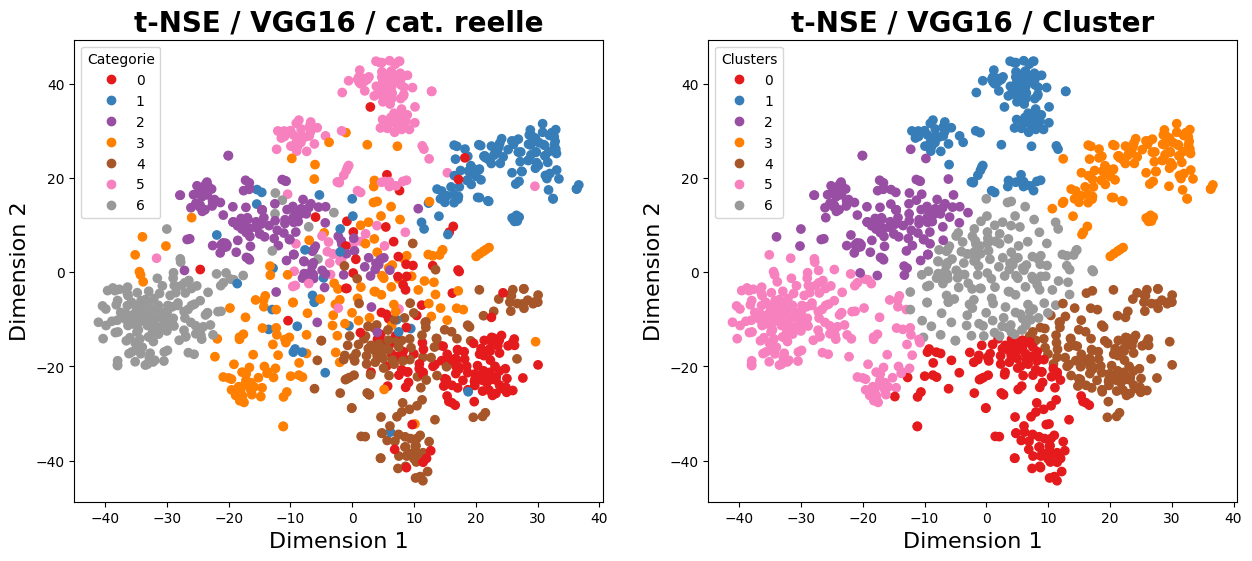

ARI :  0.476


In [60]:
comparatif_t_nse_clusters(
    X_tsne_vgg, labels_reel, cls_labels_vgg, ARI_vgg, "VGG16")

### <span style='background:black'>d/ Analyse par classe</span>

Nous comptons le nombre de mot par cluster, puis nous associons chaque
cluster à une classe réelle.

Nous visualisons la matrice de confusion après l'association.

cluster
0    137
1    132
2    138
3    133
4    142
5    196
6    172
Name: tsne1, dtype: int64


Sum of rows: [150 150 150 150 150 150 150]
Sum of columns: [137 132 138 133 142 196 172]

Correspondance des clusters :  [4 5 2 1 0 6 3]

Matrice de confusion transformée :


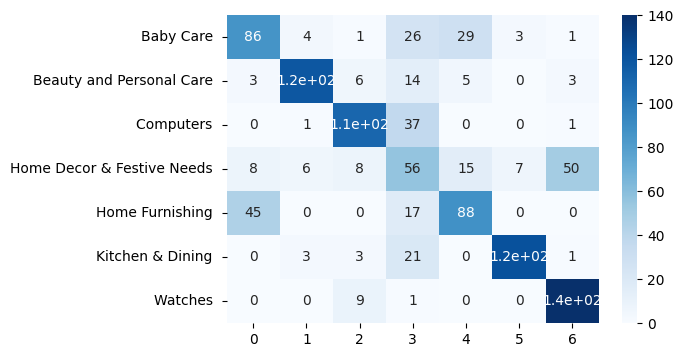

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       150
           1       0.89      0.79      0.84       150
           2       0.80      0.74      0.77       150
           3       0.33      0.37      0.35       150
           4       0.64      0.59      0.61       150
           5       0.92      0.81      0.87       150
           6       0.71      0.93      0.81       150

    accuracy                           0.69      1050
   macro avg       0.70      0.69      0.69      1050
weighted avg       0.70      0.69      0.69      1050



In [61]:
# Analyse par classe avec matrice de confusion transformée
conf_mat_vgg_df = analyse_par_classe(
    X_tsne_vgg, cls_labels_vgg, labels_reel_s, categories)

Le f1-score et l'accuracy sont proches de 70%. Le modèle est relativement performant.

<div class="alert alert-block alert-info">
<b>
<u>Bilan</u><br>
CNN Transfer Learning - VGG16
</b> :
Nous remarquons que les catégories réelles et les catégories issues du clustering ont des similitudes sans pour autant être parfaitements séparées. 
Cette intuition est confirmée par le score ARI qui est correct (> 0,4). Cette méthode semble donc être la plus performante pour notre classification automatique.
</div>

# <span style='background:blue'>Conclusion</span>

L'élaboration d'un moteur de classification automatique de produits à partir de leur image nous parait possible. En effet, nous avons obtenu des scores de similarité entre les catégories réelles et les catégories issues du clustering qui sont corrects (> 0,4) avec l'algorithme de CNN Transfer Learning - VGG16.

**L'élaboration d'un moteur de classification automatique de produits à partir de leur image présente les meilleurs résultats.**

In [62]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée totale pour faire tourner le notebook : 8 minute(s) 34 seconde(s)
